# Loading the Dataset

In [137]:
import tiktoken
import nltk
import math

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.utils import class_weight

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE, StupidBackoff, Laplace

from tqdm import tqdm
from collections import Counter, defaultdict

tqdm.pandas()
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [146]:
movies_details_df = pd.read_json('/kaggle/input/IMDB_movie_details.json', lines=True)
display(movies_details_df.head())

reviews_df = pd.read_json('/kaggle/input/IMDB_reviews.json', lines=True)
display(reviews_df.head())

,movie_id,plot_summary,duration,genre,rating,release_date,plot_synopsis
0,tt0105112,"Former CIA analyst, Jack Ryan is in England wi...",1h 57min,"[Action, Thriller]",6.9,1992-06-05,"Jack Ryan (Ford) is on a ""working vacation"" in..."
1,tt1204975,"Billy (Michael Douglas), Paddy (Robert De Niro...",1h 45min,[Comedy],6.6,2013-11-01,Four boys around the age of 10 are friends in ...
2,tt0243655,"The setting is Camp Firewood, the year 1981. I...",1h 37min,"[Comedy, Romance]",6.7,2002-04-11,
3,tt0040897,"Fred C. Dobbs and Bob Curtin, both down on the...",2h 6min,"[Adventure, Drama, Western]",8.3,1948-01-24,Fred Dobbs (Humphrey Bogart) and Bob Curtin (T...
4,tt0126886,Tracy Flick is running unopposed for this year...,1h 43min,"[Comedy, Drama, Romance]",7.3,1999-05-07,Jim McAllister (Matthew Broderick) is a much-a...


,review_date,movie_id,user_id,is_spoiler,review_text,rating,review_summary
0,10 February 2006,tt0111161,ur1898687,True,"In its Oscar year, Shawshank Redemption (writt...",10,A classic piece of unforgettable film-making.
1,6 September 2000,tt0111161,ur0842118,True,The Shawshank Redemption is without a doubt on...,10,Simply amazing. The best film of the 90's.
2,3 August 2001,tt0111161,ur1285640,True,I believe that this film is the best story eve...,8,The best story ever told on film
3,1 September 2002,tt0111161,ur1003471,True,"**Yes, there are SPOILERS here**This film has ...",10,Busy dying or busy living?
4,20 May 2004,tt0111161,ur0226855,True,At the heart of this extraordinary movie is a ...,8,"Great story, wondrously told and acted"


# Preprocessing

## Tokenizer

In [23]:
imdb_spoilers_list = list(movies_details_df['plot_synopsis']) \
                    + list(movies_details_df['plot_summary']) \
                    + list(reviews_df['review_summary']) \
                    + list(reviews_df['review_text'])

# Work Tokenizer
imdb_spoilers_strings = " ".join(imdb_spoilers_list)
imdb_spoilers_strings_reduced = imdb_spoilers_strings[:1000000]
imdb_spoilers_tokens = word_tokenize(imdb_spoilers_strings_reduced)

# BPE Tokenizer
enc = tiktoken.encoding_for_model("gpt-4")
imdb_spoilers_tokens_bpe = enc.encode(imdb_spoilers_strings_reduced)

## Normalisation

In [ ]:
# Deleting stopword
stop_words = set(stopwords.words('english'))
imdb_spoilers_tokens = [w.lower() for w in imdb_spoilers_tokens if not w.lower() in stop_words]

# Lemmatization
lemmatizer = WordNetLemmatizer()
imdb_spoilers_tokens = [lemmatizer.lemmatize(w) for w in imdb_spoilers_tokens]

## Setup the dataFrame for the predictive models

In [132]:
# Cleaning the plot_synopsis column
plot_synopsis = movies_details_df.loc[movies_details_df['plot_synopsis'] != '', 'plot_synopsis']

# Outputs the length of the 2 category
no_spoil_length = len(movies_details_df['plot_summary'])
spoil_length = len(plot_synopsis)

# Create the appropriate dataFrame for ours models : Text - Is Spoil
all_texts = pd.concat([movies_details_df['plot_summary'], plot_synopsis])
spoil_categories = [0] * no_spoil_length + [1] * spoil_length
is_spoiler_df = pd.DataFrame({'text': all_texts, 'is_spoiler': spoil_categories})

# Clean the reviews df to make it more appropriate
reviews_df = reviews_df[['review_text', 'is_spoiler']]
reviews_df = reviews_df.rename(columns={'review_text': 'text'})

# Concat the two df
is_spoiler_df = pd.concat([reviews_df, is_spoiler_df], axis=0, ignore_index=True)

is_spoiler_df

,text,is_spoiler
0,"In its Oscar year, Shawshank Redemption (writt...",1
1,The Shawshank Redemption is without a doubt on...,1
2,I believe that this film is the best story eve...,1
3,"**Yes, there are SPOILERS here**This film has ...",1
4,At the heart of this extraordinary movie is a ...,1
...,...,...
576819,The film opens with a homeless man (Bud Cort) ...,1
576820,Will Freeman (Hugh Grant) is a 38-year-old bac...,1
576821,"In the year 1998, Evan Treborn (Ashton Kutcher...",1
576822,"Brandon (Michael Fassbender) is a successful, ...",1


## Noise reduction 

In [ ]:
# In a lot of review it is difficult to determine if a review is a spoil or not because there are lot of unnecessary information in the review.
# In fact, the purpose of our modele is to take a summary review of a movie and determine if the summary spoils the movie or not but in high amount of the reviews does not focus only on the summary
# Example : I love this movies, the actor were great. That is very suprising that Lyes died at the end though. And the actor were better on this movie than on the other movies. Pleases guys watch it !!
# On this example, the only part that talk really about the movie is "that is very suprising that Lyes died at the end though" but this information is hidden between another sentences. 
# Thus, we decided to remove useless sentence to have better model


# NOTE: This pickle was created by us but it is not present on the git because it is too heavy (200 MB in gzip)
is_spoiler_df_noise_reduction = pd.read_pickle('/kaggle/working/is_spoiler_df_noise_reduction.pkl') 

## Data augmentation with synonym

In [ ]:
# An idea was to increase the size of our datasset by swapping some words with their synonym but it was not very relevant with our modele
print("The code to do that was not push to the git because it was useless, TODO: Find it to show to the teacher that we did it")

## Adding more parameter to the models

In [ ]:
# The idea is to count the number of word that are very close to `spoil` or `spoiler` like : reveals, divulge etc...
def count_spoil_words(string):
    count = 0
    for word in string.split():
        if word in spoiler_list:
            count += 1    
    return count

wv =  KeyedVectors.load('/kaggle/input/word2vec/word2vec.wordvectors', mmap='r')
spoiler_list = [word for word, _ in wv.most_similar("spoil", topn=40)] + [word for word, _ in  wv.most_similar("spoiler", topn=40)]
is_spoiler_df['count_spoil'] = is_spoiler_df['text'].progress_apply(count_spoil_words)

# Models

In [134]:
X = is_spoiler_df['text']
y = is_spoiler_df['is_spoiler']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## N-grams

In [23]:
# We want to generate only the good review
reviews_df = pd.read_json('/kaggle/input/IMDB_reviews.json', lines=True)
good_review = reviews_df.loc[reviews_df['rating'] == 10].review_text

X_train, X_test= train_test_split(good_review, test_size=0.2, random_state=24)

In [97]:
def count_ngrams(tokens, n):
    ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]    
    return Counter(ngrams)

def calculate_ngram_probabilities(train_tokens, n, test_tokens, k=0.00001): 
    vocab = set(train_tokens)
    V = len(vocab)
    ngram_counts = count_ngrams(train_tokens, n)
    n_minus_one_gram_counts = count_ngrams(train_tokens, n-1)
    ngram_probabilities = defaultdict(float)
    
    for ngram in ngram_counts:
        prefix = ngram[:-1]
        ngram_counts[ngram] += k
        n_minus_one_gram_counts[prefix] += k
        ngram_probabilities[ngram] = (ngram_counts[ngram] + k) / (n_minus_one_gram_counts[prefix] + k*V)

    for i in range(len(test_tokens)-n+1):
        ngram = tuple(test_tokens[i:i+n])
        if ngram not in ngram_counts:
            ngram_counts[ngram] = k
            prefix = ngram[:-1]
            if prefix not in n_minus_one_gram_counts:
                n_minus_one_gram_counts[prefix] = k
            ngram_probabilities[ngram] = (ngram_counts[ngram] + k) / (n_minus_one_gram_counts[prefix] + k*V)
    
    return ngram_probabilities

train_strings = " ".join(X_train[:1000])
train_tokens = word_tokenize(train_strings.lower())
train_tokens = [word for word in train_tokens if word.isalnum()]

test_strings = " ".join(X_test[:1000])
test_tokens = word_tokenize(test_strings.lower())
test_tokens = [word for word in test_tokens if word.isalnum()]

vocab = set(train_tokens)
ngram_probabilities = calculate_ngram_probabilities(train_tokens, 4, test_tokens)

In [98]:
def calculate_perplexity(test_tokens, ngram_probabilities, n):
    log_probability_sum = 0
    ngram_count = 0
    
    for i in range(len(test_tokens)-n+1):
        ngram = tuple(test_tokens[i:i+n])
        log_probability_sum += math.log2(ngram_probabilities[ngram])
        ngram_count += 1
    
    average_log_probability = -log_probability_sum / ngram_count
    perplexity = math.pow(2, average_log_probability)
    
    return perplexity

train_perplexity = calculate_perplexity(train_tokens, ngram_probabilities, 4)
test_perplexity = calculate_perplexity(test_tokens, ngram_probabilities, 4)

print("Train perplexity: ", train_perplexity)
print("Test perplexity: ", test_perplexity)

Train perplexity:  1.5178801571978164
Test perplexity:  7859.655869811526


In [125]:
def greedy_sampling(context, vocab, ngram_probabilities, n, max_length = 50):
    sentence = []
    context = context[-(n-1):]
    
    for i in range(max_length):
        probs = dict()
        for v in vocab:
            ngram = list(context)
            ngram.append(v)
            ngram = tuple(ngram)
         
            
            probs[v] = ngram_probabilities[ngram]

        best_token = max(probs, key=probs.get) 

        if probs[best_token] == 0:
            print("prob = 0")
            return sentence
        
        sentence.append(best_token)
        context = list(context)[1:]
        context.append(best_token)
        context = tuple(context)
            
    return sentence


context = ['It', 'is', 'a', 'story', 'of', 'one', 'man']
sentence = greedy_sampling(context, vocab, ngram_probabilities, 4, max_length = 200)
print(" ".join(context) + " " +  " ".join(sentence))

It is a story of one man journey to discover his identity value and purpose in life is not defined by the things and positions he seeks and pursues in society but by how he is motivated to serve and help others no matter how much people view her as a villain who thrived on kaos and mayhem maggie gyllenhall christain bale gary oldman michael caine morgan freeman and aaron erkhart all gave such oomph to their roles technically the movie was a bit tired of those hollywood movies that just try to make things fun but totally lifeless ang lee the hulk is exactly what i was looking for in these types of action comic based movie it was a great movie and it exceeded my expectations the story and the characters in the film is that it is it real how could they do this i have never seen a movie like this before it is a great movie and it exceeded my expectations the story and the characters in the film is that it is it real how could they do this i have never seen a movie like this before it is a 

## Bayesian Model

In [135]:
# This model is not very efficient for the recall, we will talk about that in the rapport

model = make_pipeline(CountVectorizer(ngram_range = (2,2)), MultinomialNB())

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.77      0.96      0.85     84677
           1       0.65      0.20      0.31     30688

    accuracy                           0.76    115365
   macro avg       0.71      0.58      0.58    115365
weighted avg       0.74      0.76      0.71    115365



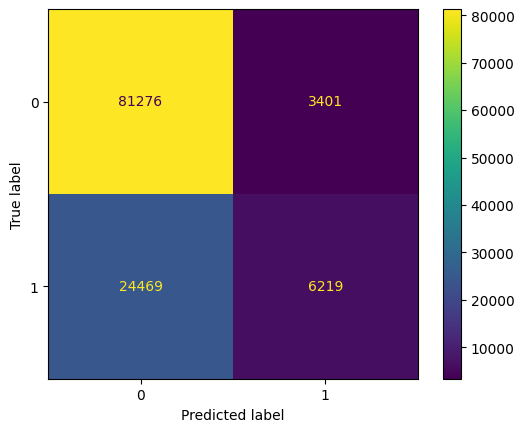

In [140]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

## Logistic Regression

In [142]:
# There are better implementation of the logistic Regression in another notebook

model = make_pipeline(CountVectorizer(stop_words="english"), TfidfTransformer(), LogisticRegression(random_state=42, class_weight="balanced", max_iter = 1000))


cross_val_predict(model, X_train, y_train, cv=5)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

              precision    recall  f1-score   support

           0       0.86      0.75      0.80     84677
           1       0.48      0.66      0.56     30688

    accuracy                           0.72    115365
   macro avg       0.67      0.70      0.68    115365
weighted avg       0.76      0.72      0.73    115365



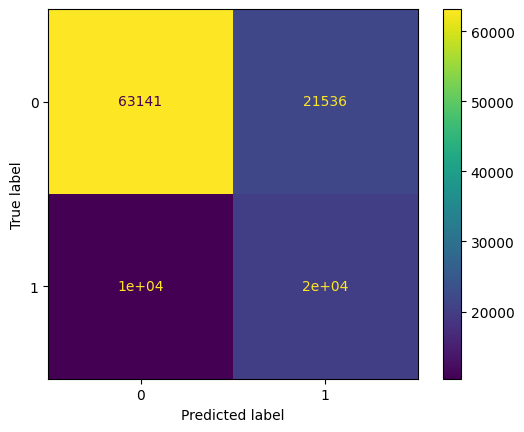

In [144]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

## Feedforward Neural Network

#### There are other version of the FNN in other notebook

In [ ]:
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)


X = is_spoiler_df['text'].progress_apply(remove_stopwords)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100  
X_train_pad = pad_sequences(X_train_seq, maxlen=1000)
X_val_pad = pad_sequences(X_val_seq, maxlen=1000)

In [34]:
model = Sequential([
    layers.Embedding(len(tokenizer.word_index) + 1, 64, input_length=1000),
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

weight = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train.values, epochs=5, batch_size=32, class_weight=dict(enumerate(weight)), validation_data=(X_val_pad, y_test.values))

Epoch 1/3

14421/14421 ━━━━━━━━━━━━━━━━━━━━ 118s 8ms/step - accuracy: 0.6661 - loss: 0.6128 - val_accuracy: 0.7341 - val_loss: 0.5633

Epoch 2/3

14421/14421 ━━━━━━━━━━━━━━━━━━━━ 108s 7ms/step - accuracy: 0.7489 - loss: 0.5165 - val_accuracy: 0.7037 - val_loss: 0.5562

Epoch 3/3

14421/14421 ━━━━━━━━━━━━━━━━━━━━ 108s 7ms/step - accuracy: 0.8239 - loss: 0.3858 - val_accuracy: 0.7398 - val_loss: 0.5574


3606/3606 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


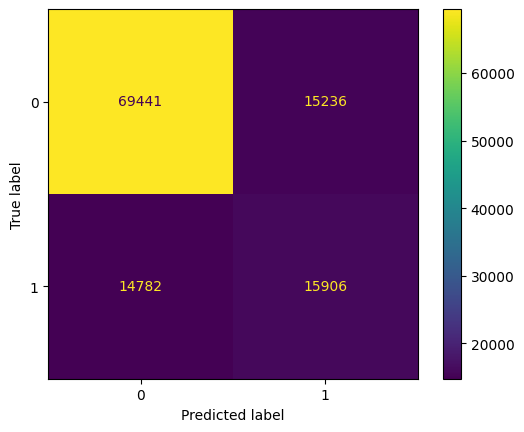

In [35]:
y_pred = (model.predict(X_val_pad) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## Logistic Regression for ratings

In [147]:
# Extract
review_rating_df = reviews_df[['review_text', 'rating']]
summary_rating_df = reviews_df[['review_summary', 'rating']]

# Rename
review_rating_df  = review_rating_df.rename(columns={'review_text': 'text'})
summary_rating_df =  summary_rating_df.rename(columns={'review_summary': 'text'})

# Rating_df
rating_df = pd.concat([review_rating_df, summary_rating_df], axis=0, ignore_index=True)

In [148]:
X = rating_df['text']
y = rating_df['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = make_pipeline(TfidfVectorizer(stop_words="english"), LogisticRegression(random_state=42, class_weight="balanced", C=1, solver='liblinear', max_iter = 100))

cross_val_predict(model, X_train, y_train, cv=5)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()